<a href="https://colab.research.google.com/github/avilaJorge/CSE253_FinalProject/blob/master/DeepFakeDetectionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !rm -R ./Logistic_Regression/*

In [0]:
!cp *.py /content/drive/My\ Drive/CSE\ 253/PA5/PyFiles
!cp *.ipynb /content/drive/My\ Drive/CSE\ 253/PA5/PyFiles

In [0]:
# !wget https://storage.googleapis.com/img-hosting-bucket/Faces_HQ.hdf5

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Mar 11 08:28:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
%run DeepFake_Dataloader.py
%run utils.py

In [0]:
# imports pytorch
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Numpy, Matplotlib, and PIL
import numpy as np
import matplotlib.pyplot as plt

# general imports
import pprint

# My imports
from DeepFake_Dataloader import get_dataloaders
from models import LinearRegression, save_model
from utils import RunningAverage
from train import train, evaluate

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
trn_dl, val_dl, tst_dl = get_dataloaders()

In [0]:
s_epoch      = 1
num_epochs   = 300
lr_rate      = 1e-2
load_model   = False
model_name   = 'LogisticRegressionModel'
path         = '/content/Logistic_Regression'

lr_model = LinearRegression(725).to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(lr_model.parameters(), lr=lr_rate, weight_decay=1e-3, momentum=0.9)

if load_model:
    lr_model.load_state_dict(torch.load(''))

In [9]:

train_losses, valid_losses = train(lr_model, 
                                   optimizer, 
                                   criterion, 
                                   trn_dl, 
                                   val_dl,
                                   model_name,
                                   path,
                                   predicter=torch.nn.Sigmoid())

Epoch:  1
Training loss: 0.0974


Training Loss:  0.0371
Training accuracy: 99.1542%


Validation Loss:  0.0356
Validation accuracy: 99.2375%
"Best Loss": 0.035592312510642744

Validation Loss has gone up 0 times.



Epoch:  2
Training loss: 0.0267


Training Loss:  0.019
Training accuracy: 99.5458%


Validation Loss:  0.0192
Validation accuracy: 99.6125%
"Best Loss": 0.01917904607271628

Validation Loss has gone up 0 times.



Epoch:  3
Training loss: 0.0159


Training Loss:  0.0136
Training accuracy: 99.7208%


Validation Loss:  0.0142
Validation accuracy: 99.7000%
"Best Loss": 0.014237646634380022

Validation Loss has gone up 0 times.



Epoch:  4
Training loss: 0.011


Training Loss:  0.0105
Training accuracy: 99.7875%


Validation Loss:  0.011
Validation accuracy: 99.7750%
"Best Loss": 0.010999635057819505

Validation Loss has gone up 0 times.



Epoch:  5
Training loss: 0.008


Training Loss:  0.0072
Training accuracy: 99.8208%


Validation Loss:  0.0077
Validation accuracy: 99.8625%
"Best Loss": 0.007692827033765968

Validation Loss has gone up 0 times.



Epoch:  6
Training loss: 0.0067


Training Loss:  0.006
Training accuracy: 99.8542%


Validation Loss:  0.0062
Validation accuracy: 99.8750%
"Best Loss": 0.006209434710428237

Validation Loss has gone up 0 times.



Epoch:  7
Training loss: 0.0055


Training Loss:  0.0051
Training accuracy: 99.9208%


Validation Loss:  0.0054
Validation accuracy: 99.9250%
"Best Loss": 0.005366702966894659

Validation Loss has gone up 0 times.



Epoch:  8
Training loss: 0.0054


Training Loss:  0.0059
Training accuracy: 99.9000%


Validation Loss:  0.0058
Validation accuracy: 99.9250%
Validation Loss has gone up 1 times.



Epoch:  9
Training loss: 0.0047


Training Loss:  0.0044
Training accuracy: 99.9083%


Validation Loss:  0.0046
Validation accuracy: 99.9125%
"Best Loss": 0.004640302525663245

Validation Loss has gone up 0 times.



Epoch:  10
Training loss: 0.0043


Training Loss:  0.004
Training accuracy: 99.9292%


Validation Loss:  0.0044
Validation accuracy: 99.9125%
"Best Loss": 0.004386175324075988

Validation Loss has gone up 0 times.



Epoch:  11
Training loss: 0.0042


Training Loss:  0.0038
Training accuracy: 99.9292%


Validation Loss:  0.0041
Validation accuracy: 99.9125%
"Best Loss": 0.004092083233112973

Validation Loss has gone up 0 times.



Epoch:  12
Training loss: 0.0041


Training Loss:  0.0036
Training accuracy: 99.9417%


Validation Loss:  0.0038
Validation accuracy: 99.9250%
"Best Loss": 0.0037800071766555653

Validation Loss has gone up 0 times.



Epoch:  13
Training loss: 0.0042


Training Loss:  0.0034
Training accuracy: 99.9458%


Validation Loss:  0.0036
Validation accuracy: 99.9250%
"Best Loss": 0.003637878093979366

Validation Loss has gone up 0 times.



Epoch:  14
Training loss: 0.0036


Training Loss:  0.0036
Training accuracy: 99.9375%


Validation Loss:  0.0037
Validation accuracy: 99.9250%
Validation Loss has gone up 1 times.



Epoch:  15
Training loss: 0.004


Training Loss:  0.0033
Training accuracy: 99.9542%


Validation Loss:  0.0034
Validation accuracy: 99.9375%
"Best Loss": 0.0034322141436859965

Validation Loss has gone up 0 times.



Epoch:  16
Training loss: 0.0038


Training Loss:  0.0032
Training accuracy: 99.9500%


Validation Loss:  0.0033
Validation accuracy: 99.9375%
"Best Loss": 0.003310412849440047

Validation Loss has gone up 0 times.



Epoch:  17
Training loss: 0.0034


Training Loss:  0.0047
Training accuracy: 99.9375%


Validation Loss:  0.0046
Validation accuracy: 99.9500%
Validation Loss has gone up 1 times.



Epoch:  18
Training loss: 0.0033


Training Loss:  0.0048
Training accuracy: 99.9042%


Validation Loss:  0.0045
Validation accuracy: 99.9375%
Validation Loss has gone up 0 times.



Epoch:  19
Training loss: 0.0033


Training Loss:  0.0031
Training accuracy: 99.9542%


Validation Loss:  0.0031
Validation accuracy: 99.9500%
"Best Loss": 0.0030590173379991138

Validation Loss has gone up 0 times.



Epoch:  20
Training loss: 0.0034


Training Loss:  0.0031
Training accuracy: 99.9500%


Validation Loss:  0.0034
Validation accuracy: 99.9250%
Validation Loss has gone up 1 times.



Epoch:  21
Training loss: 0.0033


Training Loss:  0.0039
Training accuracy: 99.9500%


Validation Loss:  0.0038
Validation accuracy: 99.9625%
Validation Loss has gone up 2 times.



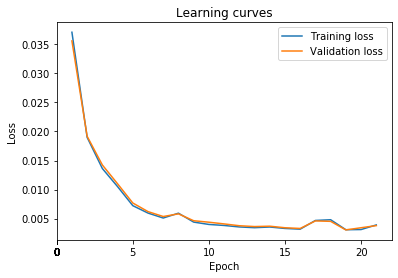

In [10]:
epochs = range(1, len(train_losses) + 1)
epoch_ticks = [i if i % 5 == 0 else 0 for i in epochs]
    
# plt.figure(figsize=(10,6))
plt.plot(epochs, train_losses, label='Training loss')
plt.plot(epochs, valid_losses, label='Validation loss')
plt.legend()
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

In [0]:
# import numpy as np
# import matplotlib.pyplot as plt
# import pickle

# num = 5
# LR = 0
# SVM = 0
# SVM_r = 0
# SVM_p = 0


# for z in range(num):
#     # read python dict back from the file
#     data = None
#     lbls = None
#     og_d = None
#     with h5py.File(fhq_hdf5_pt, 'r') as hdf5_file: 
#         data = hdf5_file['fft_data'][:]
#         lbls = hdf5_file['lbl_data'][:]
#         og_d = hdf5_file['orgn_data'][:]

#     X = data 
#     y = lbls 


#     try:

#         from sklearn.model_selection import train_test_split
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

#         from sklearn.svm import SVC
#         svclassifier = SVC(kernel='linear')
#         svclassifier.fit(X_train, y_train)
#         #print('Accuracy on test set: {:.3f}'.format(svclassifier.score(X_test, y_test)))
               
#         from sklearn.svm import SVC
#         svclassifier_r = SVC(C=3.1, kernel='rbf', gamma=0.00002)
#         svclassifier_r.fit(X_train, y_train)
#         #print('Accuracy on test set: {:.3f}'.format(svclassifier_r.score(X_test, y_test)))
                
#         from sklearn.svm import SVC
#         svclassifier_p = SVC(kernel='poly')
#         svclassifier_p.fit(X_train, y_train)
#         #print('Accuracy on test set: {:.3f}'.format(svclassifier_p.score(X_test, y_test)))
        
#         from sklearn.linear_model import LogisticRegression
#         logreg = LogisticRegression(solver='liblinear', max_iter=1000)
#         logreg.fit(X_train, y_train)
#         #print('Accuracy on test set: {:.3f}'.format(logreg.score(X_test, y_test)))

        
#         SVM+=svclassifier.score(X_test, y_test)
#         SVM_r+=svclassifier_r.score(X_test, y_test)
#         SVM_p+=svclassifier_p.score(X_test, y_test)
#         LR+=logreg.score(X_test, y_test)

 
#     except:
#         num-=1
#         print(num)
    
# print("Average SVM: "+str(SVM/num))
# print("Average SVM_r: "+str(SVM_r/num))
# print("Average SVM_p: "+str(SVM_p/num))
# print("Average LR: "+str(LR/num))